# %% [markdown]
# # Compute embeddings (real vs synthetic) — notebook
# This notebook computes per-window embeddings using the trained **Embedder**.
# It:
# 1. loads scaler and data (real test + saved synthetic windows),
# 2. restores the trained embedder (reconstruction or adversarial checkpoint),
# 3. computes mean-pooled embeddings per window,
# 4. saves embeddings to `outputs/embeddings/`.
#
# Run this notebook in your project root with the virtualenv activated.

In [1]:
# %%
# Cell 1 - Robust imports & basic paths
import os, sys, pickle, numpy as np, tensorflow as tf
import importlib.util

# Fix working directory - if running from src, go up to project root
if os.path.basename(os.getcwd()) == 'src':
    os.chdir('..')
PROJECT_ROOT = os.getcwd()

print("Project root:", PROJECT_ROOT)
print("Python exe:", sys.executable)
print("tensorflow version:", tf.__version__)

DATA_DIR = "data/processed/stock_prices"
SYN_PATH = "outputs/synth/synth_data_2000w.npy"
RECON_CKPT_DIR = "outputs/checkpoints/recon"
ADV_CKPT_DIR = "outputs/checkpoints/timegan_adv"
OUT_DIR = "outputs/embeddings"
os.makedirs(OUT_DIR, exist_ok=True)

# locate src/timegan_tf.py from project root
src_path = os.path.join(PROJECT_ROOT, "src", "timegan_tf.py")
if not os.path.exists(src_path):
    raise FileNotFoundError(f"Expected src/timegan_tf.py at: {src_path}")

# import module from file path
spec = importlib.util.spec_from_file_location("module_timegan_src", src_path)
module_timegan_src = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module_timegan_src)

print("Loaded module symbols:", [n for n in dir(module_timegan_src) if not n.startswith("_")])
if hasattr(module_timegan_src, "Embedder"):
    Embedder = module_timegan_src.Embedder
    print("Embedder loaded OK from src/timegan_tf.py")
else:
    raise ImportError("Embedder not found in src/timegan_tf.py")

Project root: c:\Abdullah_Stock-Prices_Training_2
Python exe: c:\Abdullah_Stock-Prices_Training_2\venv\Scripts\python.exe
tensorflow version: 2.20.0
Loaded module symbols: ['Discriminator', 'Embedder', 'Generator', 'Model', 'Recovery', 'Supervisor', 'layers', 'rnn_block', 'tf']
Embedder loaded OK from src/timegan_tf.py


In [2]:
# %%
# Cell 2 - Load scaler and datasets
with open(os.path.join(DATA_DIR, "scalers.pkl"), "rb") as f:
    scalers = pickle.load(f)  # This is a list of scalers

real = np.load(os.path.join(DATA_DIR, "test.npy"))
print("Real (scaled) shape:", real.shape)

synth_inv = np.load(SYN_PATH)
print("Synth (inverse-scaled) shape:", synth_inv.shape)
n, T, D = synth_inv.shape

# Scale the synthetic data using the list of scalers
synth_scaled = np.zeros_like(synth_inv)

for feature_idx in range(D):
    feature_data = synth_inv[:, :, feature_idx].reshape(-1, 1)
    scaled_feature = scalers[feature_idx].transform(feature_data)
    synth_scaled[:, :, feature_idx] = scaled_feature.reshape(n, T)

print("Synth (scaled) shape:", synth_scaled.shape)

Real (scaled) shape: (3382, 168, 5)
Synth (inverse-scaled) shape: (2000, 168, 5)
Synth (scaled) shape: (2000, 168, 5)


In [3]:
# %%
# Cell 3 - Build Embedder model and try to restore weights
HIDDEN_DIM = 64
NUM_LAYERS = 2
feature_dim = real.shape[2]

embedder = Embedder(input_dim=feature_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS)
# Warm-build (call once)
_ = embedder(tf.zeros([1, T, feature_dim]))

# Try to restore from reconstruction checkpoint first, then adversarial
ckpt = tf.train.Checkpoint(embedder=embedder)
restored = False

mgr_recon = tf.train.CheckpointManager(ckpt, RECON_CKPT_DIR, max_to_keep=3)
if mgr_recon.latest_checkpoint:
    ckpt.restore(mgr_recon.latest_checkpoint).expect_partial()
    print("Restored recon embedder from:", mgr_recon.latest_checkpoint)
    restored = True
else:
    mgr_adv = tf.train.CheckpointManager(ckpt, ADV_CKPT_DIR, max_to_keep=5)
    if mgr_adv.latest_checkpoint:
        ckpt.restore(mgr_adv.latest_checkpoint).expect_partial()
        print("Restored adv embedder from:", mgr_adv.latest_checkpoint)
        restored = True

if not restored:
    raise SystemExit("No embedder checkpoint found. Ensure recon or adv ckpt dirs exist.")

Restored recon embedder from: outputs/checkpoints/recon\ckpt-3


In [4]:
# %%
# Cell 4 - Helper: compute mean-pooled embeddings in batches
def compute_embeddings(arr, model, batch_size=64):
    """Compute mean-pooled embeddings per window.
    arr: numpy array (N, T, D)
    model: tf.keras.Model embedder returning (b, T, H)
    returns: numpy array (N, H)
    """
    out = []
    N = arr.shape[0]
    for i in range(0, N, batch_size):
        b = arr[i:i+batch_size]
        h = model(b, training=False).numpy()   # (b, T, H)
        h_mean = h.mean(axis=1)                # (b, H)
        out.append(h_mean)
    return np.concatenate(out, axis=0)

In [5]:
# %%
# Cell 5 - Compute embeddings and save
real_emb = compute_embeddings(real, embedder, batch_size=64)
synth_emb = compute_embeddings(synth_scaled, embedder, batch_size=64)

print("Real embeddings shape:", real_emb.shape)
print("Synth embeddings shape:", synth_emb.shape)

np.save(os.path.join(OUT_DIR, "real_emb.npy"), real_emb)
np.save(os.path.join(OUT_DIR, "synth_emb.npy"), synth_emb)
print("Saved embeddings to", OUT_DIR)

Real embeddings shape: (3382, 64)
Synth embeddings shape: (2000, 64)
Saved embeddings to outputs/embeddings


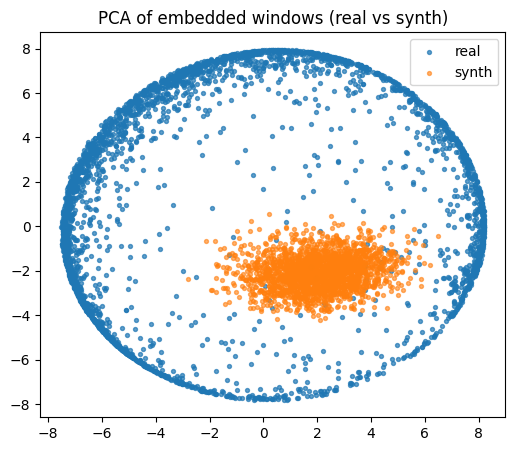

In [6]:
# %%
# Cell 6 - Quick visualization (optional): PCA to check embeddings shape
# (This is a fast check before running t-SNE/UMAP)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X = np.vstack([real_emb, synth_emb])
Z = pca.fit_transform(X)
n_real = real_emb.shape[0]
plt.figure(figsize=(6,5))
plt.scatter(Z[:n_real,0], Z[:n_real,1], s=8, label='real', alpha=0.7)
plt.scatter(Z[n_real:,0], Z[n_real:,1], s=8, label='synth', alpha=0.6)
plt.legend(); plt.title("PCA of embedded windows (real vs synth)"); plt.show()

In [7]:
# %%
# Cell 7 - Save a short manifest for reproducibility
manifest = {
    "real_emb_shape": real_emb.shape,
    "synth_emb_shape": synth_emb.shape,
    "embedder_checkpoint_recon": mgr_recon.latest_checkpoint if mgr_recon.latest_checkpoint else None,
    "embedder_checkpoint_adv": mgr_adv.latest_checkpoint if 'mgr_adv' in globals() and mgr_adv.latest_checkpoint else None,
    "synth_source": SYN_PATH,
}
import json
with open(os.path.join(OUT_DIR, "embeddings_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)
print("Wrote manifest.")

Wrote manifest.
